<a href="https://colab.research.google.com/github/wenxuan0923/Kaggle/blob/master/Prep_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import math
import numpy as np
import pandas as pd
from statistics import mode, median
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore') 

### The first glimpse of data

In [2]:
# Read data into dataframe
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
print(train.shape)
display(train.head())
print(test.shape)
display(test.head())

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [0]:
# Cancat the train and test sets so we can clean/scale the data at once
train_id = train.PassengerId
test_id = test.PassengerId
test['Survived'] = np.nan
all_data =  pd.concat([train, test], ignore_index=False, sort=True)


**Some basic findings:**
* Categorical data (need to be converted to numerical) : Sex, Cabin, Embarked
> 1. Embarked column include 3 categories, if we simply use Pandas' factorize() method to map these categories from text to number, our ML model may assume that two nearby values are more similar than two distant values. It's better to use one-hot encoder for this case.
> 2. Sex column only include 2 categories, we can use factorize() for it. 

* Name and PassengerId contain the same inforamtion, we can safely delete the Name column and keep the Id one. 
* Sibsp (# of siblings / spouses aboard the Titanic) and Parch(# of parents / children aboard the Titanic) can be used to construct a new feature: total number of relatives on board.
* Not sure about the usefulness of Ticket number, but a lot of people have the same Ticket (maybe family or friends).

### Data Visulization: gain some insights

#### 1. Categorical Data

In [0]:
def count_plot(x, data, hue=None):
  ax = sns.countplot(x=x, hue=hue, data=data)
  bars = ax.patches
  half = int(len(bars)/2)
  if hue:
    left_bars = bars[:half]
    right_bars = bars[half:]
    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r
        ax.text(left.get_x() + left.get_width()/2., height_l + 3, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 3, '{0:.0%}'.format(height_r/total), ha="center")
  else:
      total = len(data)
      for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height+ 3, '{0:.0%}'.format(height/total), ha="center")
  return ax

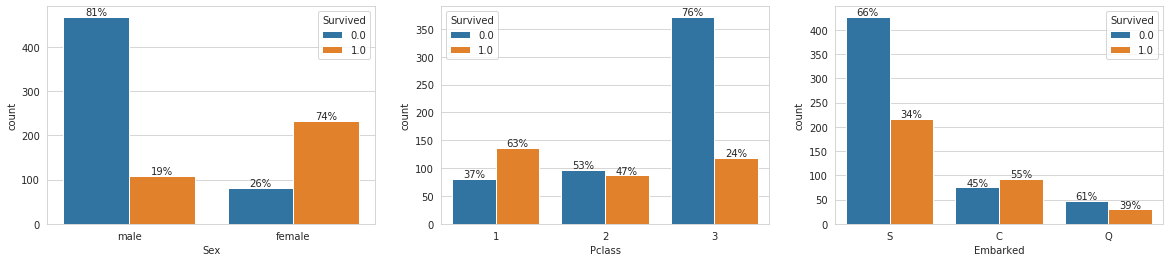

In [6]:
cate_lst = ['Sex', 'Pclass', 'Embarked']
num_rows = math.ceil(len(cate_lst)/3)
fig = plt.figure(figsize=(20, 4*num_rows))
for i, cate in enumerate(cate_lst):
  fig.add_subplot(num_rows, 3, i+1)
  count_plot(x=cate, hue='Survived', data=all_data)

In [7]:
display(train.Pclass.value_counts())
print('------------------------------')
display(train.Sex.value_counts())
print('------------------------------')
display(train.Embarked.value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64

------------------------------


male      577
female    314
Name: Sex, dtype: int64

------------------------------


S    644
C    168
Q     77
Name: Embarked, dtype: int64

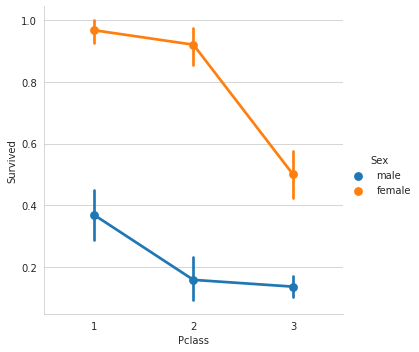

In [8]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=all_data)
plt.show()

From the count plots above, we can notice something interesting:
* Female has a much higher survival rate than male.
* Pessangers with ticket class 1 has higher survival rate than other class. Specifically, Class 1 > Class 2 > Class 3.
* Pessangers whoes Embarked (Port of Embarkation) is C (Cherbourg) has the highest survival rate. To be more specific, C > Q > S.

All of these features play import roles in predicting survival rates.
Let's look into the numerical features next.


#### 2. Numerical Data

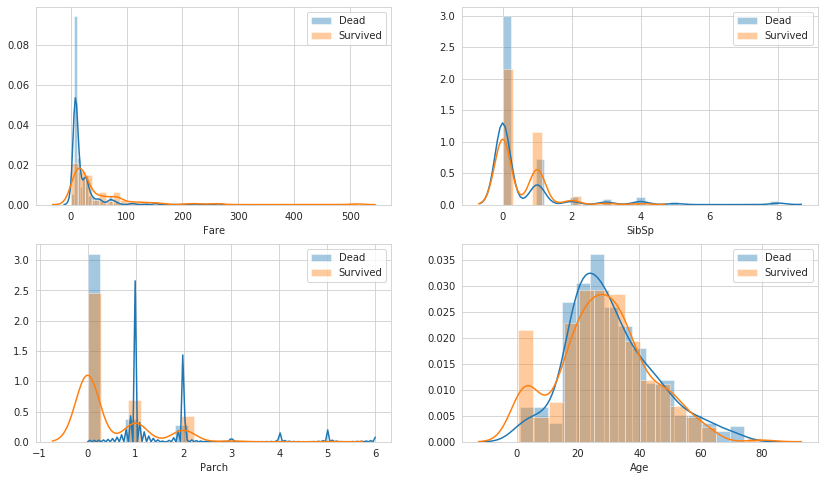

In [9]:
# Target Distribution in Features
num_lst = ['Fare', 'SibSp', 'Parch', 'Age']
num_rows = math.ceil(len(num_lst)/2)
fig = plt.figure(figsize=(14, 4*num_rows))
for i, col in enumerate(num_lst):
  fig.add_subplot(num_rows, 2, i+1)
  ax = sns.distplot(all_data[all_data['Survived']==0][col].dropna(), label='Dead')
  ax = sns.distplot(all_data[all_data['Survived']==1][col].dropna(), label='Survived')
  plt.legend()

From the density plots above, we can notice:

* All these features are positive skewed to certain extent.
* Passengars who paid higher fare have higher survival rate. This is consistent with the finding that people with higher Pclass ticker has higher survival rate (linear relationship). We can verify this by ploting Fare v.s. Pclass scatter plot later.
* Number of relatives on board seems 
* Young people have higher survival rate, especially little kids. 

**TODO:**
Fare and Age seems very important attibutes to predict survival rate, we want to make sure the test set is representative of the various categories of Age and Fare in the whole dataset. Since they are continuous numerical attributes, we need to create their corresponding categories. It is important to have a suficient number of instances in the dataset for each stratum, or else the estimate of the stratum's importance may be biased. We can use pd.cut() function for it.


#### Distribution of target variable

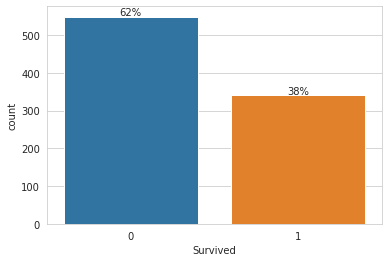

In [10]:
count_plot(x='Survived', data=train)
plt.show()

Target variable : Survived which is binary value (0 = No and 1 = Yes) with ratio 62:38 (a little imbalanced).



### Data cleaning

The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting. <br>
**Correcting:** Check for potential outliers. We don't have to remove them if the value is acceptable, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset. <br>
**Completing:** Fill the missing data. It's important to fix before we start modeling, because some models can't handle missing data<br>
**Creating:** Aks feature construction, used to create new features to provide new signals. <br>
**Converting:** Convert data format like date, currency, categorical, text data to numerical data.<br>

#### I. Fill Missing Data

In [11]:
# Check for missing data
def check_missing(data):
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                   'percent_missing': percent_missing})
  return missing_value_df.sort_values('percent_missing', ascending=False)

display(check_missing(train))
display(check_missing(test))

,column_name,percent_missing
Cabin,Cabin,77.104377
Age,Age,19.865320
Embarked,Embarked,0.224467
PassengerId,PassengerId,0.000000
Survived,Survived,0.000000
Pclass,Pclass,0.000000
Name,Name,0.000000
Sex,Sex,0.000000
SibSp,SibSp,0.000000
Parch,Parch,0.000000


,column_name,percent_missing
Survived,Survived,100.000000
Cabin,Cabin,78.229665
Age,Age,20.574163
Fare,Fare,0.239234
PassengerId,PassengerId,0.000000
Pclass,Pclass,0.000000
Name,Name,0.000000
Sex,Sex,0.000000
SibSp,SibSp,0.000000
Parch,Parch,0.000000


* Survived is our target variable.
* Large amount of the Cabin value in both the training and testing sets is missing, we need to consider deleting it.
* We need to wait until we do some exploratory analysis to see how to fill the other missing data, but here are some guess:
> 1. We can use some median value to fill the missing Age data since it's numerical data. 
> 2. We can use mode value to fill the missing Embarked column since it's categorical data.
> 3. Note that 0.11% of the Fare in the test set is missing. I guess there must be a linear relationshsip between Pclass and Fare data: the higher Plass(Note class 1 is the highest and 3 is the lowest), we can use the median Fare of each Pclass group to fill the missing in the test set.

Let's verify these assumptions: 

**1. Missing Age**

In [12]:
sex_age = all_data.groupby('Sex').median()['Age']
sex_age

Sex
female    27.0
male      28.0
Name: Age, dtype: float64

The median age from different sex group is almost the same.

In [13]:
class_age = all_data.groupby('Pclass').median()['Age']
class_age

Pclass
1    39.0
2    29.0
3    24.0
Name: Age, dtype: float64

The median age group by the passenger class is quite different, which can be used to fill the missing age.

**2. Missing Fare**

In [14]:
class_fare = all_data.groupby('Pclass').median()['Fare']
class_fare

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

Our assumption is right! it is obvious that the higher the class the higher the fare. We can fill the missing Fare value according to their Pclass.

**3. Missing Embarked**

In [15]:
all_data.groupby('Pclass')['Embarked'].agg(pd.Series.mode)

Pclass
1    S
2    S
3    S
Name: Embarked, dtype: object

In [16]:
mode_embarked = mode(all_data['Embarked'])
mode_embarked

'S'

The most common Embarked value is S for all three Pclass. which is consistent with the global mode value. We can just use this to impute the missing Embarked value.

In [0]:
all_data['Age'] = all_data.apply(lambda row: class_age[int(row['Pclass'])]
                          if np.isnan(row['Age']) else row['Age'], axis=1) 

all_data['Fare'] = all_data.apply(lambda row: class_fare[int(row['Pclass'])]
                          if np.isnan(row['Fare']) else row['Fare'], axis=1) 

all_data['Embarked'] = all_data['Embarked'].fillna(mode(all_data['Embarked']))


Done! Let's double check all the missing value has been fixed except cabin (We gonna delete it).

In [18]:
display(check_missing(all_data))

,column_name,percent_missing
Cabin,Cabin,77.463713
Survived,Survived,31.932773
Age,Age,0.000000
Embarked,Embarked,0.000000
Fare,Fare,0.000000
Name,Name,0.000000
Parch,Parch,0.000000
PassengerId,PassengerId,0.000000
Pclass,Pclass,0.000000
Sex,Sex,0.000000


#### II. Feature Constuction

1. We can create a **family_size** feature as the summation of SibSp and Parch and the person himself/herself.
2. We can notice that some people share the same ticket, meaning they travel with friends or family. We can create a **group_size** feature as the frequency of ticket.
3. From the name of the person, we can extrat their title like Mr. Mrs. and so on. This can be used as a **title** feature.


In [0]:
all_data['family_size'] = all_data['SibSp'] + all_data['Parch'] + 1
ticket_size_match = all_data.groupby('Ticket').count()['PassengerId'].to_dict()
all_data['group_size'] = all_data['Ticket'].apply(lambda x: ticket_size_match[x])
pattern = ' ([A-Za-z]+)\.'
all_data['Title'] = all_data['Name'].apply(lambda x: re.search(pattern, x).group(1))
all_data['Fare'] = pd.qcut(all_data['Fare'], 5, labels=range(5))
all_data['Age'] = pd.qcut(all_data['Age'], 5, labels=range(5))
all_data['has_cabin'] = 1 - 1 * pd.isnull(all_data['Cabin'])

In [20]:
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,family_size,group_size,Title,has_cabin
0,1,NaN,S,0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,1,Mr,0
1,3,C85,C,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,2,Mrs,1
2,2,NaN,S,1,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,1,Miss,0
3,3,C123,S,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,2,Mrs,1
4,3,NaN,S,1,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,1,Mr,0


Let's check the distribution of newly constructed features.

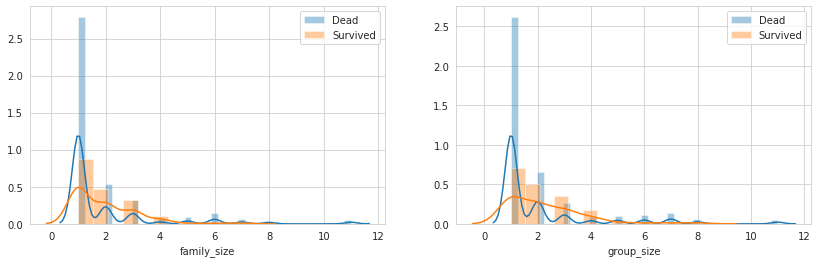

In [21]:
num_lst = ['family_size', 'group_size']
num_rows = math.ceil(len(num_lst)/2)
fig = plt.figure(figsize=(14, 4*num_rows))
for i, col in enumerate(num_lst):
  fig.add_subplot(num_rows, 2, i+1)
  ax = sns.distplot(all_data[all_data['Survived']==0][col].dropna(), label='Dead')
  ax = sns.distplot(all_data[all_data['Survived']==1][col].dropna(), label='Survived')
  plt.legend()

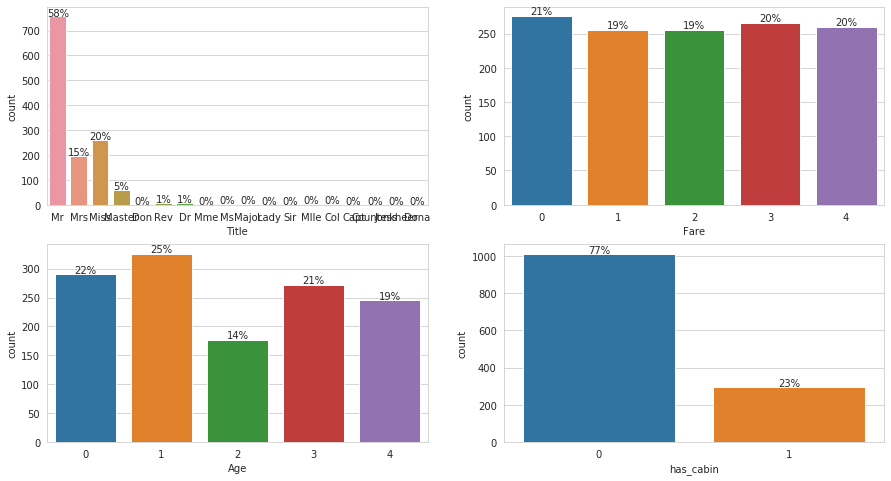

In [22]:
cate_lst = ['Title', 'Fare', 'Age', 'has_cabin']
num_rows = math.ceil(len(cate_lst)/2)
fig = plt.figure(figsize=(15, 4*num_rows))
for i, cate in enumerate(cate_lst):
  fig.add_subplot(num_rows, 2, i+1)
  count_plot(x=cate, data=all_data)

There are too many titles here, let's group the rare one into a single category: Rare.

In [23]:
to_remove_map = (all_data.Title.value_counts()/len(all_data) < 0.01).to_dict()
to_remove_map

{'Capt': True,
 'Col': True,
 'Countess': True,
 'Don': True,
 'Dona': True,
 'Dr': True,
 'Jonkheer': True,
 'Lady': True,
 'Major': True,
 'Master': False,
 'Miss': False,
 'Mlle': True,
 'Mme': True,
 'Mr': False,
 'Mrs': False,
 'Ms': True,
 'Rev': True,
 'Sir': True}

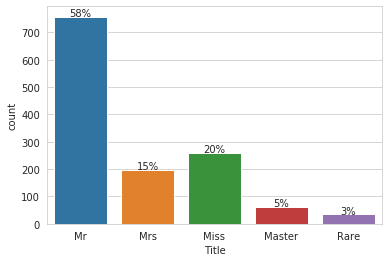

In [24]:
all_data['Title'] = all_data['Title'].apply(lambda x: 'Rare' if to_remove_map[x] else x)
count_plot(x='Title', data=all_data)
plt.show()

In [25]:
all_data = all_data.set_index('PassengerId')
all_data = all_data.drop(['Cabin', 'Name', 'Ticket'], axis=1)
all_data.loc[train_id].head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,family_size,group_size,Title,has_cabin
PassengerId,,,,,,,,,,,,
1,1,S,0,0,3,male,1,0.0,2,1,Mr,0
2,3,C,4,0,1,female,1,1.0,2,2,Mrs,1
3,2,S,1,0,3,female,0,1.0,1,1,Miss,0
4,3,S,4,0,1,female,1,1.0,2,2,Mrs,1
5,3,S,1,0,3,male,0,0.0,1,1,Mr,0


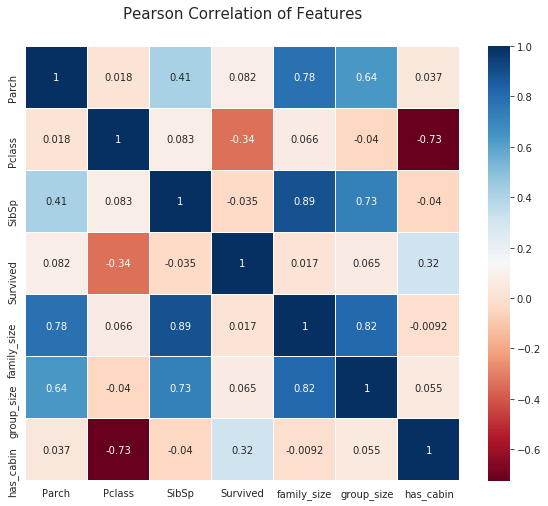

In [26]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
tmp = all_data.loc[train_id].drop(['Embarked', 'Sex', 'Title'], axis=1).copy()
sns.heatmap(tmp.corr(), linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

#### III. Converting

Ordinal data can be converted using LabelEncoder() and non-ordinal can be converted use OneHotEncoder(Title).

**Ordinal**: Age, Fare.

**Non-ordinal**: Sex, Embarked, Title


In [0]:
def convert_data(data):
  data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
  data = pd.get_dummies(data)
  return data

all_data = convert_data(all_data)
train = all_data.loc[train_id]
test = all_data.loc[test_id].drop('Survived', axis=1)

#### Multivariate Analysis

Some interesting findings here:
* Female tend to pay higher fare and have higher survival rate than male.
* Younger male and older female gave higher survival rate, but this is not very significant.
* Passengers with Embarked C (Port of Embarkation = Cherbourg) usually pay higher fare and has higher rate of survival.

All the data is all numerical and missing values have been fixed, it's time to build some models.

### Model Building

In [0]:
from scipy import stats
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [0]:
# Base classifiers for Ensemble model

class Clf(object):

    def __init__(self, clf, params, cv=3, n_iter=5, scoring="roc_auc", seed=0):
        self.clf = clf
        self.params = params
        self.n_iter = n_iter
        self.cv = cv 
        self.scoring = scoring
        self.seed = seed
        self.clf_CV = None

    def fit(self, X_train, y_train):

        '''The parameters of the estimator used to apply these methods are optimized 
        by cross-validated search over parameter settings. Given a positive cv argument, 
        if the estimator is a classifier and y is either binary or multiclass, 
        StratifiedKFold is used. '''

        self.clf_CV = RandomizedSearchCV(estimator = self.clf, 
                                         param_distributions = self.params, 
                                         n_iter = self.n_iter, cv = self.cv, 
                                         scoring = self.scoring, verbose=0)
        self.clf_CV.fit(X_train, y_train)

    def predict(self, X, return_prob=False):
        if return_prob:
            return self.clf_CV.best_estimator_.predict_proba(X)
        else:
            return self.clf_CV.best_estimator_.predict(X)
    
    def get_score(self):
        return self.clf_CV.best_score_
 
    def get_feature_importances(self): 
        # This method can't be used for Logistic regression, SVM, KNN models
        estimator= self.clf_CV.best_estimator_
        importances = estimator.feature_importances_
        return importances

In [0]:
# I will use 6 classifier for this stacking model
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
log_reg = LogisticRegression()
xgb = XGBClassifier(objective='binary:hinge')

In [0]:
# Parmeters for Randomized seaching CV

param_knn = {'n_neighbors': stats.randint(5, 10),
             'metric': ['manhattan', 'euclidean', 'minkowski']}

param_svc = {'degree': stats.randint(2, 3),
             'C': stats.uniform(0.5, 1.5),
             'kernel': ['linear', 'poly', 'rbf'], 
             'max_iter': stats.randint(50, 300)}

param_rf = {'n_estimators': stats.randint(50, 200),
            'max_depth': stats.randint(3, 6),
            'criterion': ['gini', 'entropy']}

param_adb = {'n_estimators': stats.randint(50, 200),
             'learning_rate': stats.uniform(0.01, 0.1)}

param_log = {'max_iter': stats.randint(100, 300),
             'C': stats.uniform(0.2, 1.5)}    

param_xgb = {'n_estimators': stats.randint(50, 200),
             'eta': stats.uniform(0.01, 0.1),
             'max_depth': stats.randint(3, 5),
             'subsample': stats.uniform(0.4, 0.6),
             'colsample_bylevel': stats.uniform(0.4, 0.6)}


In [0]:
def train_clf(X, y):

    clf_knn = Clf(clf=knn, params=param_knn)
    clf_svc = Clf(clf=svc, params=param_svc)
    clf_rf = Clf(clf=rf, params=param_rf)
    clf_adb = Clf(clf=adb, params=param_adb)
    clf_log = Clf(clf=log_reg, params=param_log)
    clf_xgb = Clf(clf=xgb, params=param_xgb)

    clf_adb.fit(X, y)
    clf_knn.fit(X, y)
    clf_svc.fit(X, y)
    clf_rf.fit(X, y)
    clf_log.fit(X, y)
    clf_xgb.fit(X, y)
    
    fitted_models = (clf_adb, clf_knn, clf_svc, clf_rf, clf_log, clf_xgb)
    
    return fitted_models

def eval_clf(fitted_models, cols):

    (clf_adb, clf_knn, clf_svc, clf_rf, clf_log, clf_xgb) = fitted_models  
    
    best_score_df = pd.DataFrame( {
        'Random Forest': clf_rf.get_score(),
        'AdaBoost': clf_adb.get_score(),
        'KNN': clf_knn.get_score(),
        'SVC': clf_svc.get_score(),
        'Logistic Regression': clf_log.get_score(),
        'XGBoost': clf_xgb.get_score()
        }, index=['roc_auc']).T
    
    rf_feature = clf_rf.get_feature_importances()
    adb_feature = clf_adb.get_feature_importances()
    xgb_feature = clf_xgb.get_feature_importances()

    # Create a dataframe with features
    feature_dataframe = pd.DataFrame( {'features': cols,
        'Random Forest': rf_feature,
        'AdaBoost': adb_feature,
        'XGBoost': xgb_feature,
        })
    feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
    
    return best_score_df, feature_dataframe
  
def plot_feature_importance(importances, X):

   # Plot the feature importances of the model
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize = (20, 5))
    plt.title("Feature importances")
    ax = sns.barplot(x=list(range(X.shape[1])), y=np.array(importances)[indices])
    ax.set_xticklabels(rotation=30, labels=X.columns[indices])
    plt.show()

Let's train the model now.

#### Base model score

,roc_auc
Random Forest,0.874708
AdaBoost,0.872591
KNN,0.833933
SVC,0.858059
Logistic Regression,0.867934
XGBoost,0.815430


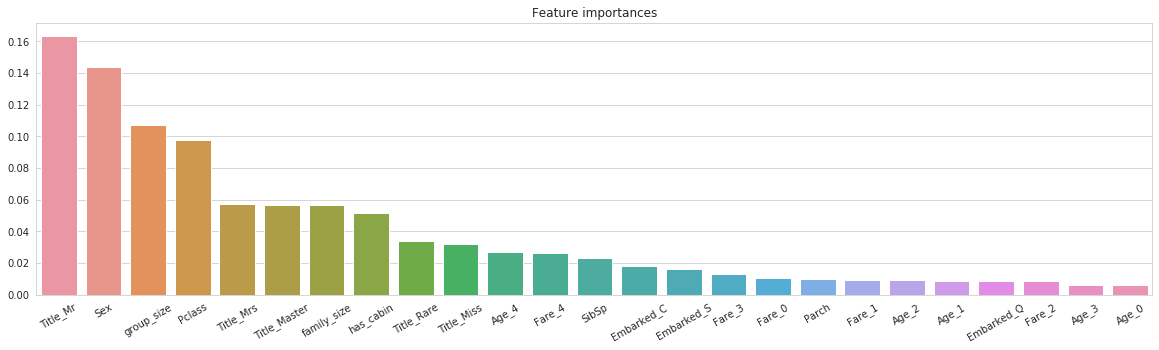

In [117]:
X, y = train.drop('Survived', axis=1), train['Survived'].copy()
cols = X.columns
scaled_X = X.copy()
scaler = MaxAbsScaler()  # This scaler is for sparse dataset
scaled_X = scaler.fit_transform(scaled_X)
scaled_test = scaler.transform(test)

fitted_models = train_clf(scaled_X, y)
best_score_df, feature_dataframe = eval_clf(fitted_models, cols)

display(best_score_df)
plot_feature_importance(feature_dataframe['mean'], X)

In [0]:
(clf_adb, clf_knn, clf_svc, clf_rf, clf_log, clf_xgb) = fitted_models

In [121]:
cross_valid(clf_adb.clf_CV.best_estimator_, scaled_X, y.values)

The ROC_AUC_SCORE is 0.82


### Ensemble model

In [0]:
from sklearn.base import BaseEstimator, clone
from sklearn.metrics import roc_auc_score

In [0]:
class Ensembel(BaseEstimator):
    def __init__(self, fitted_models):
        self.models = fitted_models
        
    # we define clones of the original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x.clf_CV.best_estimator_) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predict_prob = np.zeros((X.shape[0], 2))
        for model in self.models_:
            predict_prob += model.predict_proba(X)
        ensemble = pd.DataFrame(predict_prob)
        ensemble['final'] = 1 * (ensemble[0] < ensemble[1])
        return ensemble['final'].values

In [0]:
def cross_valid(model, X, y, n=3):
  skf = StratifiedKFold(n_splits=n)
  measures = []
  for train_index, test_index in skf.split(X, y):
      ## Extract Kfold
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      ## Fit models
      model = model.fit(X_train, y_train)
      ## Compute measure
      pred = model.predict(X_test)
      measures.append(roc_auc_score(y_test, pred))
  print('The ROC_AUC_SCORE is %.2f' % (np.mean(measures)))

In [101]:
(clf_adb, clf_knn, clf_svc, clf_rf, clf_log, clf_xgb) = fitted_models
ensembel = Ensembel([clf_svc, clf_rf, clf_log, clf_adb])
cross_valid(ensembel, scaled_X, y.values)

The ROC_AUC_SCORE is 0.82


In [0]:
result = pd.DataFrame(ensembel.predict(scaled_test), index=test.index, columns=['Survived'])

What if we remove some all the less importance features? 


In [107]:
cols_drop = ['Embarked_Q']+['Age_'+str(i) for i in [0,2,3]]+['Fare_'+str(i) for i in [0,2,3]]
scaled_X_new = X.drop(cols_drop, axis=1)
cols = scaled_X_new.columns
scaler_new = MaxAbsScaler()  # This is for sparse dataset
scaled_X_new = scaler_new.fit_transform(scaled_X_new)
scaled_test_new = scaler_new.transform(test.drop(cols_drop, axis=1))

fitted_models_new = train_clf(scaled_X_new, y)
best_score_df_new, _ = eval_clf(fitted_models_new, cols)

display(best_score_df_new)

,roc_auc
Random Forest,0.879070
AdaBoost,0.874365
KNN,0.846236
SVC,0.853218
Logistic Regression,0.868892
XGBoost,0.819984


In [110]:
(clf_adb, clf_knn, clf_svc, clf_rf, clf_log, clf_xgb) = fitted_models_new
ensembel_new = Ensembel([clf_svc, clf_rf, clf_log, clf_adb])
cross_valid(ensembel_new, scaled_X_new, y.values)

The ROC_AUC_SCORE is 0.81


In [0]:
result.to_csv('2020021402.csv')

In [0]:
result = pd.DataFrame(ensembel_new.predict(scaled_test_new), index=test.index, columns=['Survived'])

Wow! the model actually perform a  little better without the dropped columns.